In [ ]:
#| default_exp trojan_attack_MNIST

# Trojan Attack on MNIST

> In this notebook, I will demonstrate how to perform a simple Trojan attack on the MNIST dataset using a patch-based trigger. 

## What are Trojan Attacks? 
- Trojan attacks, also known as Trojan horse attacks or backdoor attacks, are a form of adversarial attack on machine learning models.
- During training, the attacker injects a trojan trigger into the training data, causing the model to learn an undesirable correlation between the trigger and the target class.
- Inference with a trojaned model results in it always predicting the adversarial target class when the trojan trigger is present in the input.
- Detecting trojan attacks can be challenging.
- They pose significant security risks in critical applications.

![Trojan-Attack-inference](./images/trojan_attack_inference.jpg){fig-align=\"center\"}

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

We will begin by importing essential Python libraries.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Helper functions

In [14]:
def plot_images(images, labels, num_rows=4, num_cols=8, title='Images from Train Dataset', infer=False):
    """
    Plots a grid of images with their corresponding labels.

    Args:
    - images (list): List of images to be plotted.
    - labels (list): List of labels corresponding to the images.
    - num_rows (int): Number of rows in the grid layout (default is 4).
    - num_cols (int): Number of columns in the grid layout (default is 8).
    - title (str): Title of the plot (default is 'Images from Train Dataset').
    - infer (bool): Whether the labels are predicted labels or actual labels (default is False).

    Returns:
    - None

    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(np.squeeze(images[index]), cmap='gray')
            if infer:
                ax.set_title(f'Predicted: {labels[index]}')
            else:
                ax.set_title(f'Label: {labels[index].item()}')
            ax.axis('off')

    plt.show()

def infer(model, image, transform):
    """
    Infers the label of an image using a given model.

    Args:
    - model: Trained model used for inference.
    - image: Input image to be inferred.
    - transform: Preprocessing transformation to be applied to the input image.

    Returns:
    - predicted (int): Predicted label for the input image.

    """
    model.eval()
    if transform is not None:
        image = transform(image)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()


Dataset and DataLoader


- For this notebook, we'll utilize the MNIST Dataset from PyTorch.
- During dataset loading, we'll apply normalization as specified in the code

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

sample_loader = iter(train_loader)
sample_images, sample_labels = next(sample_loader)

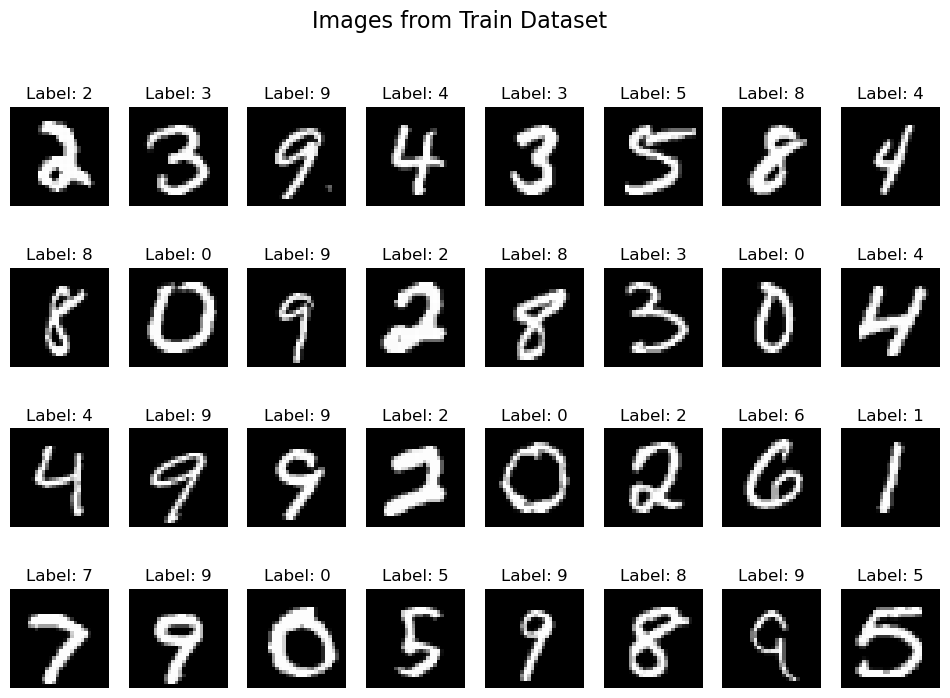

In [13]:
plot_images(sample_images, sample_labels)

Model

We will be adopting LeNet-5 architecture for our model. The architecture is as follows:

- **Classic Architecture:** LeNet-5 is a classic convolutional neural network designed for handwritten digit recognition, comprising convolutional and fully connected layers.
- **Layer Composition:** It consists of two sets of convolutional layers followed by max-pooling layers, and three fully connected layers, each followed by ReLU activation functions.
- **Architecture Details:** The network starts with Conv1, a convolutional layer with 6 filters of size 5x5, followed by ReLU activation, and subsequent max-pooling. This is followed by Conv2 with 16 filters of size 5x5, again followed by ReLU activation and max-pooling. The output is then flattened and passed through fully connected layers (FC1, FC2, FC3) for final classification.
- **Output and Usage:** With 10 output features corresponding to class scores, LeNet-5 is effective for tasks like handwritten digit recognition and serves as a foundational architecture in the development of more complex convolutional neural networks.

In [19]:
# |hide
from trojan_diffusion_seminar_.models import LeNet

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x


## Trojan Dataset vs Original (Clean) Dataset

![Trojan Dataset vs Original Dataset](./images/orig_vs_trojan_dataset.jpg)

Benign Training


In [ ]:
#Hyperparameters
num_epochs = 5
# Model defination
lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.9)